In [73]:
import pathlib
from itertools import product
import math

import torch
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from PIL import Image
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [74]:
class PatchDataset(Dataset):
    def __init__(self, image_path, transform, patch_size=32):
        self.image_path = image_path
        self.image = Image.open(image_path)
        if self.image.width % patch_size != 0 or self.image.height % patch_size != 0:
            self.image = self.image.resize((math.ceil(self.image.width/patch_size)*patch_size, math.ceil(self.image.height/patch_size)*patch_size))

        self.image_tensor = transform(self.image)

        self.patch_size = patch_size

        self.patches = self.get_patches()

        self.transform_patch = transforms.Compose([
                transforms.Resize((224, 224), antialias=True),
            ])

    def get_patches(self):
        patches = []
        for j in range(0, self.image_tensor.shape[2], self.patch_size):
            for i in range(0, self.image_tensor.shape[1], self.patch_size):
                patches.append(self.image_tensor[:, i:i+self.patch_size, j:j+self.patch_size])
        return patches

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):

        return self.transform_patch(self.patches[idx])

class Depatch():
    def __init__(self, patches_filenames, patch_size=32, image_size=(224, 224)):
        self.patches_filenames  = patches_filenames
        self.patch_size = patch_size
        self.image_size = image_size

        self.image = np.zeros((self.image_size[0], self.image_size[1], 3), dtype=np.uint8)
        self.i = 0

    def fill_patches(self, indices, colors=None):
        patches = [np.asarray(Image.open(self.patches_filenames[i]).resize((self.patch_size, self.patch_size)).convert("RGB")) for i in indices]
        if colors is not None:
            patches = [patch * color for patch, color in zip(patches, colors)]
        for patch in patches:
            y = self.i // (self.image_size[0]//self.patch_size)
            x = self.i % (self.image_size[0]//self.patch_size)
            self.image[x*self.patch_size:(x+1)*self.patch_size, y*self.patch_size:(y+1)*self.patch_size, :] = patch
            self.i += 1

In [90]:
# Load the pre-trained AlexNet model
alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1).to(device)

# Set the model to evaluation mode
alexnet.eval()

# Define the transformation to apply to the input image
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True),
    # transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = pathlib.Path("gabor-filters")
dataset = sorted(list(root.glob("*.png")))

(847, 100) (100,) (100, 9216)


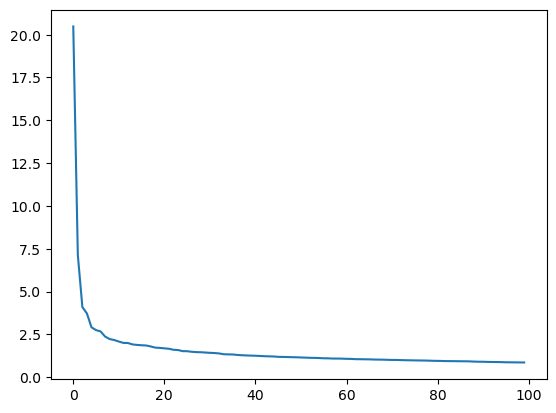

(847, 100)


In [91]:
# Load the compressed dictionary
svd = np.load("svd.npz")
U = svd["U"]
Sigma = svd["Sigma"]
Vt = svd["Vt"]
Dk = svd["Dk"]

print(U.shape, Sigma.shape, Vt.shape)
plt.plot(Sigma)
plt.show()

print(Dk.shape)

Dk_tensor = torch.from_numpy(Dk).to(torch.float32).to(device)
Vt_tensor = torch.from_numpy(Vt).to(torch.float32).to(device)


In [92]:

unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
to_pil = transforms.ToPILImage()

def make_image(img_path, batch_size, patch_size, color_mode='color'):

    img_tensor_patches = PatchDataset(img_path, transform=transform, patch_size=patch_size)
    img_tensor_patches_dataloader = DataLoader(img_tensor_patches, batch_size=batch_size, shuffle=False, num_workers=0)

    num_width = img_tensor_patches.image_tensor.shape[1] // img_tensor_patches.patch_size
    num_height = img_tensor_patches.image_tensor.shape[2] // img_tensor_patches.patch_size
    # final_image = np.zeros((patch_size*num_width, patch_size*num_height, 3), dtype=np.uint8)
    final_image = Depatch(dataset, patch_size=patch_size, image_size=(patch_size*num_width, patch_size*num_height))
    print(final_image.image.shape, num_width, num_height, img_tensor_patches.image_tensor.shape)

    for patches in tqdm(img_tensor_patches_dataloader):
        vectors = alexnet.avgpool(alexnet.features(patches.to(device))).flatten(start_dim=1)
        vectors = vectors / torch.linalg.vector_norm(vectors, dim=1, keepdim=True)
        xk = torch.matmul(vectors, Vt_tensor.T)
        index = torch.argmax(torch.abs(torch.matmul(Dk_tensor, xk.T).T), dim=1)
        match color_mode:
            case 'color':
                b = unnormalize(patches).cpu().numpy().transpose(0, 2, 3, 1).mean(axis=(1, 2), keepdims=True)
            case 'gray':
                b = unnormalize(patches).cpu().numpy().transpose(0, 2, 3, 1).mean(axis=(1, 2, 3), keepdims=True)
            case 'none':
                b = [1] * patches.shape[0]
        final_image.fill_patches(index, b)

    return final_image.image



(360, 278, 3) 180 139 torch.Size([3, 360, 278])


  0%|          | 0/782 [00:00<?, ?it/s]

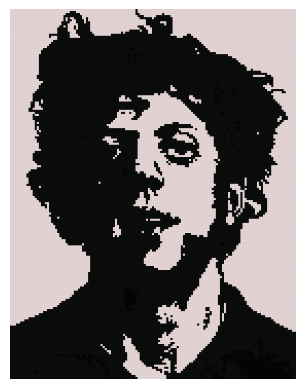

In [94]:
batch_size = 32
patch_size = 2

final_image = make_image("test-img/god.jpg", batch_size, patch_size, color_mode='none')

plt.imshow(final_image)
plt.axis("off")
plt.show()

# plt.imsave("results/god.png", final_image)
